# Eclipse Morphology Part 3: *Latent Spaces and Visualizing Them*

***Author: Marc Hon***

In the previous section, we have looked at projecting light curves down into a low-dimensional space that encodes meaningful information about the light curves' morphology. This is effectively embedding light curves into a **latent space**, an internal representation of data for which similar items are grouped together.

In this section, we will explore the concept of latent spaces by applying neural networks to the eclipsing binary dataset.

In [114]:
import os
import numpy as np
import pandas as pd
import astropy.units as u
import matplotlib.pyplot as plt
from astropy.timeseries import TimeSeries
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pathlib import Path
from collections import defaultdict

data_folder_path = Path.cwd().resolve().parent.parent / 'ml_astro' / 'chapter1' / 'data'

plt.style.use('science')
fs = 18

## Self-Organizing Maps (SOMs)

Introduced in [Kohonen (1995)](http://dx.doi.org/10.1007/978-3-642-97610-0), the Self-Organizing Map (SOM) is a neural network designed to create a low-dimensional mapping of data. The unique feature of a SOM is its structured grid of neurons. Training is performed in an __unsupervised__ manner, neurons compete to activate in a winner-takes-all fashion, with the neuron that best matches the data point being selected as the winner. This winning neuron, along with its neighboring neurons, undergoes adjustments to better represent the data, incorporating a topological neighborhood effect to ensure that similar neurons are updated together.

> ![som](https://raw.githubusercontent.com/mtyhon/ais5201/master/chapter1/images/som.png)
>
> *Figure.* Schematic of a hexagonal Self-Organizing Map. The input layer $\overrightarrow{w_i}$ has the same dimensionality as the input data $\mathbf{x}=[x_1, x_2,\cdots,x_n]$. The weights $\overrightarrow{w_s}$ connect the input layer to every hexagonal cell on the grid, with each cell comprising a neuron of the same dimensionality as the input. These weights are iteratively adjusted as the neurons learn to represent the dataset. Image from [Barecke (2008)](https://doi.org/10.1007/978-3-540-76827-2_18).


As this competitive adjustment process is extended across the entire dataset, the neurons in the trained SOM self-organize to capture and reflect the underlying diversity and structure of the data. This yields a structured, topological map that reflects the relationships and similarities within the data. Because the dataset has to be described with a finite number of neurons on the grid, the weights of individual neurons end up forming prototypes, or highly representative examples in the dataset. Because of this, SOMs are also an effective approach to clustering, as **groups of similar data points are found in the topological neighbourhood** of the prototypes in the map.

> ![som](https://raw.githubusercontent.com/mtyhon/ais5201/master/chapter1/images/gsom.webp)
>
> *Figure.* Example of a SOM being used for taxonomic classification of a metagenome data sets, presented by [Weber et al. (2010)](http://dx.doi.org/10.1038/ismej.2010.180).


We will use the efficient and minimalistic implementation of a SOM from the [`minisom`](https://github.com/JustGlowing/minisom/) library.

Following the previous part in this series, we will load in the dataset and normalize each light curve to the range between 0 and 1.

In [28]:
from minisom import MiniSom
from tslearn.preprocessing import TimeSeriesScalerMinMax

dataset = np.load(os.path.join(data_folder_path, 'KeplerEB_Filtered.npz'))
scaled_flux = TimeSeriesScalerMinMax(value_range=(0, 1)).fit_transform(dataset['flux'][:, 1, :]).squeeze()

As a quick reminder and a sanity check, let's view what we are trying to visualize from three randomly drawn samples. We are working with flux-normalized binned phase-folded light curves, which are sufficiently processed to be used by a machine learning algorithm to leverage differences in the diversity of eclipse shapes across the dataset.

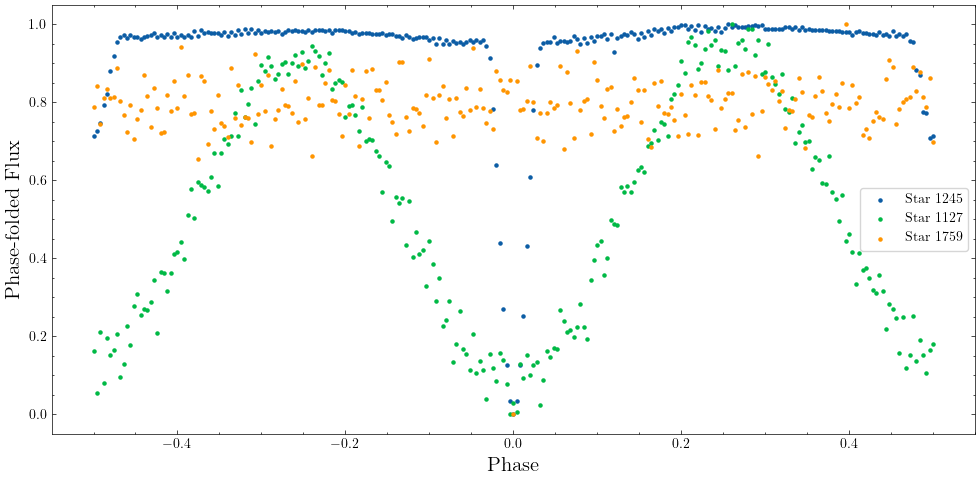

In [25]:
randint = np.random.randint(0, len(dataset['flux']), 3)
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(111)
for idx in randint:
    ax1.scatter(dataset['flux'][idx][0], scaled_ts[idx], s=5, label=f'Star {idx}')
    ax1.set_xlabel('Phase', fontsize=fs-3)
    ax1.set_ylabel('Phase-folded Flux', fontsize=fs-3)    

plt.legend(frameon=True)
plt.tight_layout(w_pad=2)
plt.show()

### SOM Hyperparameters

The size of the grid, the neighbourhood function, and its influence parameter $\sigma$ describe the granularity of the SOM and are thus important user-defined parameters to set when constructing a SOM. The **neighbourhood** function, in particular, weights the influence of a winning neuron to its neighbours, with the following implemented by `minisom`:

`gaussian` : A Gaussian with shape parameter $\sigma$. 

`mexican_hat`: A Mexican hat function with a spread factor $\sigma$.

`bubble`: Constant function with a spread of sigma in either direction. This is effectively a 2D Heaviside function.

`triangle`: Triangular function with a spread of sigma in either direction. This is similar to `bubble` except that the weights taper off linearly towards the edge.

We will adopt the `gaussian` neighbourhood function with $\sigma=1$, where the value is in units of the map's dimensions. Let's visualize a 8x8 map!

In [31]:
dim1 = 10   # width of the map
dim2 = 10   # height of the map

som = MiniSom(dim1, dim2, scaled_flux.shape[1], sigma=1, learning_rate=0.1, 
              neighborhood_function='gaussian', random_seed=10, activation_distance = 'euclidean') ## initializing the SOM object

som.pca_weights_init(scaled_flux) ## initializing the SOM weights

> **SOM Initialization**  
Observe above that the SOM weights were initialized by a function that uses the first two principal components across the dataset. In principle, this allows the weights across the map to be spread out in a way that represents the major axes of variance across the dataset, which can help with convergence.


In the following, we will train the the SOM. For each training iteration, we randomly select a sample from the data, find the sample's Best Matching Unit (BMU, also known as `som.winner`) and update it. We will also save the training errors of the SOM.

In [ ]:
training_iterations = 100000
q_error, t_error, d_error = [], [], []
for i in range(training_iterations):
    rand_i = np.random.randint(len(scaled_flux))
    som.update(scaled_flux[rand_i], som.winner(scaled_flux[rand_i]), i, training_iterations) # per sample update
    q_error.append(som.quantization_error(scaled_flux))
    t_error.append(som.topographic_error(scaled_flux))

> **Training with a 'for' loop is slow...**  
The use of an explicit `for` loop to train is for illustrative purposes in this exercise. For most applications, `minisom`'s batched training will run significantly faster by orders of magnitude:
>```python
> som.train_batch(scaled_flux, num_iteration = 100000)
>```


### SOM Error Metrics

There are two main errors to consider when training the SOM:

**Quantization Error**: Specifies how much information is lost when representing the data using the map. It is calculated as the average squared distance between the input samples and the BMU they are mapped to.

**Topographic Error**: Measures the extent to which the SOM preserves neighbourhood relationships in the data. In the case of a Gaussian neighbourhood function, we expect a smooth topological variation on the map, meaning that adjacent BMUs should be similar to one another, otherwise there is a high penalty. To calculate this error, we first identify, for each sample, their BMU and second-best matching unit. The error is calculated as the proportion of samples in the dataset for which their BMU and second-best matching units are not adjacent.

Text(0, 0.5, 'Error')

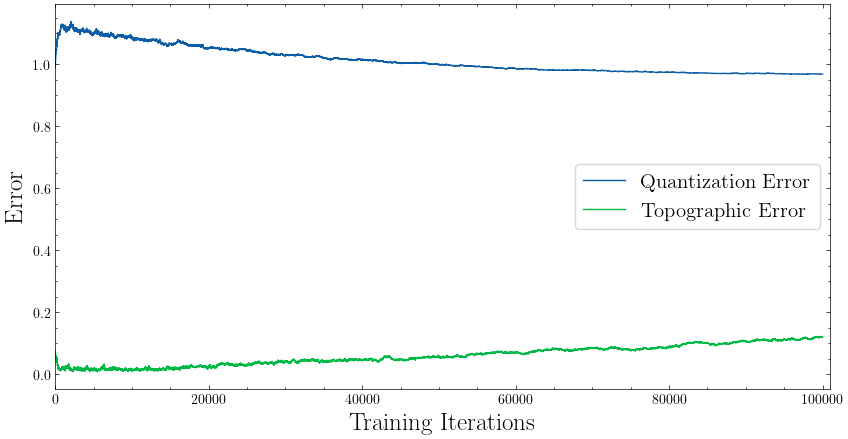

In [51]:
fig = plt.figure(figsize=(10, 5)); ax1 = fig.add_subplot(111)
ax1.plot(np.arange(training_iterations)[1:], q_error[1:], label='Quantization Error')
ax1.plot(np.arange(training_iterations)[1:], t_error[1:], label='Topographic Error')
ax1.legend(prop={'size': fs-3}, frameon=True); ax1.set_xlim(-0.5, 101000)
ax1.set_xlabel('Training Iterations', fontsize=fs); ax1.set_ylabel('Error', fontsize=fs)

As seen above, the **quantization error** steadily decreases, while the **topographic error** steadily rises in turn. What's happening with the map to cause these changes?

SOMs, just like typical supervised learning approaches, can *overfit* the data. In this instance, overfitting occurs when the neurons fixate more on matching individual examples from the dataset as opposed to preserving smooth changes across adjacent neurons. In other words, we may have very accurate archetypical representations but sacrifice the nice topological properties the trained SOMs possesses.


### Visualizing the SOM

Let us examine how the morphology of the phase-folded light curves are now distributed with the SOM.

In [52]:
win_map = som.win_map(scaled_flux) # takes the dataset and assigns them to their best-matching units (BMU)
som_weights = som.get_weights() # obtains the archetype of the light curve in each unit

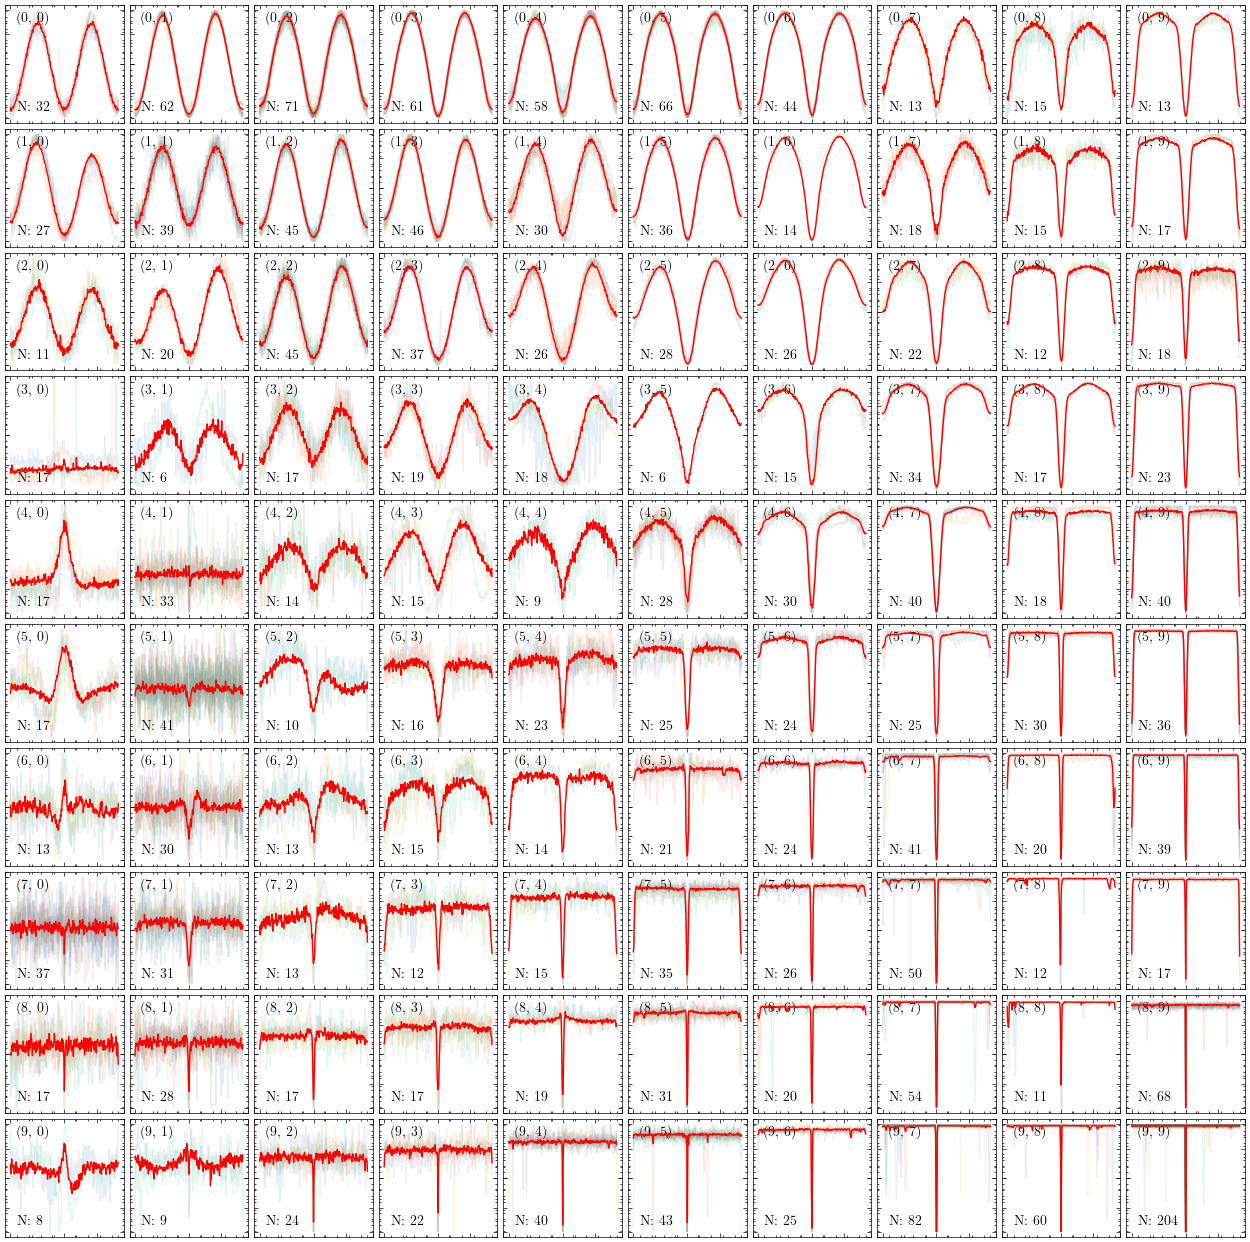

In [63]:
fig = plt.figure(figsize=(16, 16)); the_grid = plt.GridSpec(dim1, dim2, wspace=0.05, hspace= 0.05)
for position in win_map.keys():
    ax = fig.add_subplot(the_grid[position[0], position[1]], label = '1')
    ax2 = fig.add_subplot(the_grid[position[0], position[1]], label = '2', frame_on=False)
    [ax.plot(win_map[position][i], alpha=0.1) for i in range(len(win_map[position])) if i % 5 == 0]
    ax.plot(som_weights[position[0], position[1], :], c='r', zorder=3)    
    ax.text(x=0.1, y=0.1, s='N: '+ str(len(win_map[position])), transform = plt.gca().transAxes,
            fontweight='bold')
    ax.text(x=0.1, y=0.85, s=str(position), transform = plt.gca().transAxes,
            fontweight='bold')
    ax.set_xticklabels([]); ax.set_yticklabels([]);  ax2.set_xticklabels([]); ax2.set_yticklabels([])

The above shows the trained 10x10 SOM. Specifically, the grey curves correspond to individual examples that have been assigned to a particular unit or neuron on the map. The archetype, or typical example, of eclipses in each unit are shown by the red curves. **Archetypes are what the SOMs learn during their training.**

> **A Spike Instead of a Dip?**  
Why are there archetypes that have a rise in flux instead of a dip?

<details>
  <summary><strong>Hint: Astronomical Cardiology</strong> (click to expand)</summary>

> These are are a relatively rare subclass of detached binary stars with short periods ($\leq 100$ days) and high
eccentricities ($e \geq$ 0.2) known as **heartbeat stars**. They are termed as such due to the shape of the light curves resembling an electrocardiogram. 
>
> ![transit_i_a](https://raw.githubusercontent.com/mtyhon/ais5201/master/chapter1/images/hb.png)
>
> *Figure.* Image from Figure 1 of [Thompson et al. (2012)](https://iopscience.iop.org/article/10.1088/0004-637X/753/1/86/pdf).
    
</details>

-------------------------------------

For convenience, neurons/units on the map are specified with grid coordinates and the number of examples from the dataset that have been allocated to them. Let's plot a few examples drawn from a specific unit:

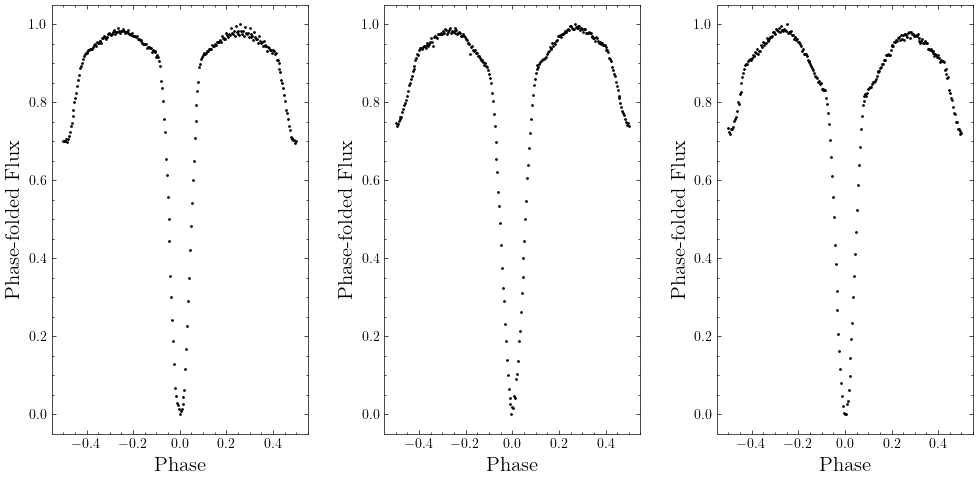

In [73]:
unit = (3,7)

## Display three random light curves from the specified unit
randint = np.random.randint(0, len(win_map[unit]), 3)

fig = plt.figure(figsize=(10, 5))
ax1, ax2, ax3 = fig.add_subplot(131), fig.add_subplot(132), fig.add_subplot(133)
for idx, ax in zip(randint,[ax1,ax2,ax3]):
    ax.scatter(dataset['flux'][idx][0], win_map[unit][idx], s=1, c='k')
    ax.set_xlabel('Phase', fontsize=fs-3)
    ax.set_ylabel('Phase-folded Flux', fontsize=fs-3)    
plt.tight_layout(w_pad=2); plt.show()

These all have similar shapes as they belong to the same unit!

### Map smoothness

Notice how the shapes of the archetypes gradually vary across the map, which highlights the SOM ability to **preserve the topological structure of the dataset** by mapping similar archetypes to nearby locations.

To quantify the smoothness of the map, we can plot the **U-Matrix** (unified distance matrix) of the SOM. The U-Matrix calculates, for the archetype in each neuron, a normalized dissimilarity distance relative to adjacent neurons. A larger dissimilarity means that the archetype represented by the neuron stands out rather distinctively from the otherwise smooth variations across the map. This property endows SOMs with the ability to identify clusters from datasets as well!

Let's visualize the U-Matrix for our dataset of eclipses:

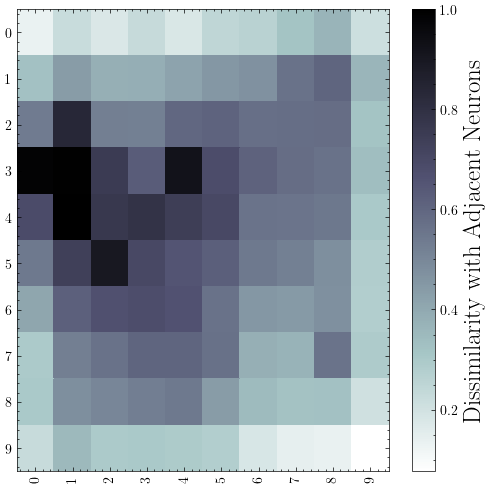

In [117]:
plt.figure(figsize=(6, 6))
plt.pcolor(som.distance_map(), cmap='bone_r') 
plt.gca().invert_yaxis()

plt.xticks(np.arange(0.5, som.distance_map().shape[1], 1), rotation=90,labels = np.arange(0, som.distance_map().shape[1], 1)) 
plt.yticks(np.arange(0.5, som.distance_map().shape[0], 1), labels = np.arange(0, som.distance_map().shape[1], 1))
cbar = plt.colorbar(); cbar.set_label('Dissimilarity with Adjacent Neurons', fontsize=fs)

> **Inspecting the U-Matrix**  
Does the U-Matrix agree with your intuition of which regions have strongly dissimilar archetypes from the earlier visualization of the SOM? Do regions of high dissimilarity correspond to neurons with drastically different eclipse shapes relative to its neighbours?


## Comparison with a Morphological Parameter

In the previous section, we have seen a morphological parameter $0\leq c\leq1$ being used to define the 'detached-ness' of the eclipse shape. Using the SOM, we can observe how this parameter is translated to our map.

Recall the following:

- A smaller $c$ indicates a more detached-like morphology
- A $c$ closer to $1$ indicates a more ellipsoidal morphology

In [96]:
kics = dataset['kic']
ebcat = pd.read_csv(os.path.join(data_folder_path, 'eb_morph.dat')).drop_duplicates(subset='kic')

def bin_quantity_win_map(som, data, quantity):
    ## Same as Minisom's win map, except that the dictionary contains a quantity (e.g. depth or duration)
    ## binned into position (i,j)
    winmap = defaultdict(list)
    for i, x in enumerate(data):
        winmap[som.winner(x)].append(quantity[i])
    return winmap

morph_win_map = bin_quantity_win_map(som, scaled_flux, np.array([ebcat.morph.values[np.where(ebcat.kic.values == k)[0][0]] for k in kics]))

The parameter `morph_win_map` maps $c$ based on the assignment of samples in the dataset. Let us visualize the median value of the morphological parameter assigned to each neuron in the SOM.

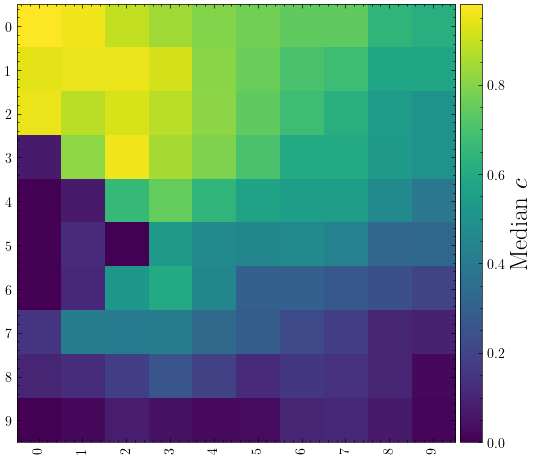

In [116]:
morph_image = np.zeros((dim1, dim2))
for position in morph_win_map.keys():
    morph_image[position] = np.median(morph_win_map[position])

plt.figure(figsize=(6, 6))
im = plt.imshow(morph_image, vmin=0)
plt.xticks(np.arange(0., som.distance_map().shape[1], 1), rotation=90,labels = np.arange(0, som.distance_map().shape[1], 1)) 
plt.yticks(np.arange(0., som.distance_map().shape[0], 1), labels = np.arange(0, som.distance_map().shape[1], 1))
divider = make_axes_locatable(plt.gca()); cax = divider.append_axes("right", size="5%", pad=0.05) 
cbar = plt.colorbar(im, cax=cax); cbar.set_label('Median $c$', fontsize=fs)

Notice that this agrees with what we expect from the SOM neuron archetypes!


> **Assignment**
>
> SOMs are incredibly versatile tools, with various hyperparameters that can be changed to further improve its performance to achieve optimal performance on the desired task (e.g., clustering, classification).
> 
> Experiment with changing **two** of the following:
>
> - The map's dimensions
> - The map topology from square to hexagonal (see [this notebook](https://github.com/JustGlowing/minisom/blob/master/examples/HexagonalTopology.ipynb))
>  -The type of neighbourhood function (`gaussian`, `bubble`, '`mexican_hat`, `triangle`) and/or its corresponding influence parameter $\sigma$
>
> For each variation, create a visualization of the SOM as presented in the plot of the `win_map` above, where the type of variation is **clearly indicated**. Which variation creates clear projections of the dataset for visualization?


## See also

[Binary Visualizer](https://danhey.com/orbviz/)
